In [ ]:
# inspired by lazyprogrammer


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy.data as ttd




In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns = ['labels', 'data']

In [ ]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [ ]:
df2 = df[['data', 'b_labels']]

In [ ]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df2.to_csv('spam2.csv', index=False)

In [ ]:
TEXT = ttd.Field(sequential=True, batch_first=True, lower=False, pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)


dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)



In [ ]:
train_dataset, test_dataset = dataset.split() # default is 0.7

In [ ]:
TEXT.build_vocab(train_dataset,)

In [ ]:
vocab = TEXT.vocab

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_iter, test_iter = ttd.Iterator.splits(
        (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
        batch_sizes=(32, 256), device=device)

        

In [ ]:
# shape of embedding --> (N x T x D)


embed = nn.Embedding(len(vocab), 20).to(device)

for inputs, targets in train_iter:
  out = embed(inputs)
  print("input shape:", inputs.shape, "output shape:", out.shape)
  break



input shape: torch.Size([32, 36]) output shape: torch.Size([32, 36, 20])


In [ ]:
class CNN(nn.Module):

  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()

    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs


    self.embed = nn.Embedding(self.V, self.D)

    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
    
    self.fc = nn.Linear(128, self.K)
  


  def forward(self, X):

    out = self.embed(X)

    # output of embedding --> (N, T, D)
    # conv1d expects --> (N, D, T)

    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    out = out.permute(0, 2, 1)    # changing back

    out, _ = torch.max(out, 1)    # max pool
    
    out = self.fc(out)
    
    
    return out


In [ ]:
model = CNN(len(vocab), 20, 1).to(device)
model


CNN(
  (embed): Embedding(12608, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)


  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []


    for inputs, targets in train_iter:

      targets = targets.view(-1, 1).float()

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())


    train_loss = np.mean(train_loss)
    


    test_loss = []
    
    for inputs, targets in test_iter:
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())


    test_loss = np.mean(test_loss)




    train_losses[it] = train_loss
    test_losses[it] = test_loss
    


    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  
  return train_losses, test_losses



In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 8)


Epoch 1/8, Train Loss: 0.3698,       Test Loss: 0.4061, Duration: 0:00:00.522363
Epoch 2/8, Train Loss: 0.2534,       Test Loss: 0.2464, Duration: 0:00:00.482966
Epoch 3/8, Train Loss: 0.1692,       Test Loss: 0.1860, Duration: 0:00:00.492887
Epoch 4/8, Train Loss: 0.1146,       Test Loss: 0.2028, Duration: 0:00:00.479830
Epoch 5/8, Train Loss: 0.0828,       Test Loss: 0.1409, Duration: 0:00:00.482954
Epoch 6/8, Train Loss: 0.0531,       Test Loss: 0.1357, Duration: 0:00:00.530131
Epoch 7/8, Train Loss: 0.0371,       Test Loss: 0.1574, Duration: 0:00:00.534883
Epoch 8/8, Train Loss: 0.0248,       Test Loss: 0.1567, Duration: 0:00:00.481926


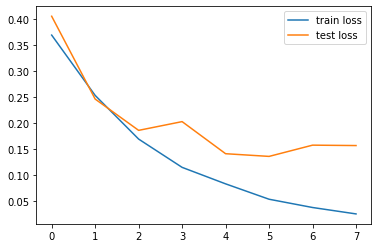

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:

n_correct = 0.
n_total = 0.



for inputs, targets in train_iter:

  targets = targets.view(-1, 1).float()

  outputs = model(inputs)

  predictions = (outputs > 0)
  
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]


train_acc = n_correct / n_total




n_correct = 0.
n_total = 0.


for inputs, targets in test_iter:

  targets = targets.view(-1, 1).float()

  outputs = model(inputs)

  predictions = (outputs > 0)
  
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]


test_acc = n_correct / n_total



print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.9964, Test acc: 0.9450
